# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 19            
model_seed = 9           

# --- Training configuration ---
epochs = 700            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/700: Train Loss 2.3098 | Test Loss 2.2742 | accs Train 0.1167 Test 0.2133


Epoch 100/700: Train Loss 0.0000 | Test Loss 2.1569 | accs Train 1.0000 Test 0.6822


Epoch 200/700: Train Loss 0.0000 | Test Loss 2.1329 | accs Train 1.0000 Test 0.6852


Epoch 300/700: Train Loss 0.0000 | Test Loss 2.1152 | accs Train 1.0000 Test 0.6868


Epoch 400/700: Train Loss 0.0000 | Test Loss 2.1007 | accs Train 1.0000 Test 0.6897


Epoch 500/700: Train Loss 0.0000 | Test Loss 2.0891 | accs Train 1.0000 Test 0.6907


Epoch 600/700: Train Loss 0.0000 | Test Loss 2.0803 | accs Train 1.0000 Test 0.6917


Epoch 700/700: Train Loss 0.0000 | Test Loss 2.0731 | accs Train 1.0000 Test 0.6927
Completed training with 0 additional samples of data
Epoch 1/700: Train Loss 2.3066 | Test Loss 2.2479 | accs Train 0.0867 Test 0.3795


Epoch 100/700: Train Loss 0.0006 | Test Loss 0.8434 | accs Train 1.0000 Test 0.8728


Epoch 200/700: Train Loss 0.0002 | Test Loss 0.8912 | accs Train 1.0000 Test 0.8752


Epoch 300/700: Train Loss 0.0001 | Test Loss 0.9241 | accs Train 1.0000 Test 0.8754


Epoch 400/700: Train Loss 0.0001 | Test Loss 0.9491 | accs Train 1.0000 Test 0.8760


Epoch 500/700: Train Loss 0.0001 | Test Loss 0.9694 | accs Train 1.0000 Test 0.8758


Epoch 600/700: Train Loss 0.0000 | Test Loss 0.9862 | accs Train 1.0000 Test 0.8763


Epoch 700/700: Train Loss 0.0000 | Test Loss 1.0004 | accs Train 1.0000 Test 0.8762
Completed training with 540 additional samples of data
Epoch 1/700: Train Loss 2.3046 | Test Loss 2.2450 | accs Train 0.0980 Test 0.4105


Epoch 100/700: Train Loss 0.0052 | Test Loss 0.4290 | accs Train 1.0000 Test 0.9097


Epoch 200/700: Train Loss 0.0008 | Test Loss 0.5015 | accs Train 1.0000 Test 0.9114


Epoch 300/700: Train Loss 0.0003 | Test Loss 0.5376 | accs Train 1.0000 Test 0.9114


Epoch 400/700: Train Loss 0.0002 | Test Loss 0.5624 | accs Train 1.0000 Test 0.9112


Epoch 500/700: Train Loss 0.0001 | Test Loss 0.5810 | accs Train 1.0000 Test 0.9110


Epoch 600/700: Train Loss 0.0001 | Test Loss 0.5962 | accs Train 1.0000 Test 0.9110


Epoch 700/700: Train Loss 0.0001 | Test Loss 0.6088 | accs Train 1.0000 Test 0.9110
Completed training with 1940 additional samples of data
Epoch 1/700: Train Loss 2.3047 | Test Loss 2.2430 | accs Train 0.0915 Test 0.4262


Epoch 100/700: Train Loss 0.0378 | Test Loss 0.2552 | accs Train 0.9937 Test 0.9310


Epoch 200/700: Train Loss 0.0024 | Test Loss 0.3302 | accs Train 1.0000 Test 0.9354


Epoch 300/700: Train Loss 0.0008 | Test Loss 0.3704 | accs Train 1.0000 Test 0.9366


Epoch 400/700: Train Loss 0.0004 | Test Loss 0.3972 | accs Train 1.0000 Test 0.9371


Epoch 500/700: Train Loss 0.0002 | Test Loss 0.4164 | accs Train 1.0000 Test 0.9370


Epoch 600/700: Train Loss 0.0002 | Test Loss 0.4315 | accs Train 1.0000 Test 0.9373


Epoch 700/700: Train Loss 0.0001 | Test Loss 0.4439 | accs Train 1.0000 Test 0.9370
Completed training with 5940 additional samples of data
Epoch 1/700: Train Loss 2.3050 | Test Loss 2.2419 | accs Train 0.0932 Test 0.4412


Epoch 100/700: Train Loss 0.0995 | Test Loss 0.1568 | accs Train 0.9722 Test 0.9535


Epoch 200/700: Train Loss 0.0120 | Test Loss 0.1495 | accs Train 0.9988 Test 0.9628


Epoch 300/700: Train Loss 0.0020 | Test Loss 0.1816 | accs Train 1.0000 Test 0.9630


Epoch 400/700: Train Loss 0.0008 | Test Loss 0.2004 | accs Train 1.0000 Test 0.9637


Epoch 500/700: Train Loss 0.0004 | Test Loss 0.2138 | accs Train 1.0000 Test 0.9638


Epoch 600/700: Train Loss 0.0003 | Test Loss 0.2235 | accs Train 1.0000 Test 0.9639


Epoch 700/700: Train Loss 0.0002 | Test Loss 0.2312 | accs Train 1.0000 Test 0.9641
Completed training with 19940 additional samples of data
Epoch 1/700: Train Loss 2.3049 | Test Loss 2.2418 | accs Train 0.0930 Test 0.4308


Epoch 100/700: Train Loss 0.1178 | Test Loss 0.1275 | accs Train 0.9663 Test 0.9626


Epoch 200/700: Train Loss 0.0338 | Test Loss 0.0813 | accs Train 0.9920 Test 0.9758


Epoch 300/700: Train Loss 0.0085 | Test Loss 0.0898 | accs Train 0.9992 Test 0.9775


Epoch 400/700: Train Loss 0.0025 | Test Loss 0.1074 | accs Train 0.9999 Test 0.9763


Epoch 500/700: Train Loss 0.0011 | Test Loss 0.1192 | accs Train 1.0000 Test 0.9759


Epoch 600/700: Train Loss 0.0006 | Test Loss 0.1276 | accs Train 1.0000 Test 0.9759


Epoch 700/700: Train Loss 0.0004 | Test Loss 0.1343 | accs Train 1.0000 Test 0.9756
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.0731 | accs: 0.6927
 540 samples | Test Loss: 1.0004 | accs: 0.8762
1940 samples | Test Loss: 0.6088 | accs: 0.9110
5940 samples | Test Loss: 0.4439 | accs: 0.9370
19940 samples | Test Loss: 0.2312 | accs: 0.9641
59940 samples | Test Loss: 0.1343 | accs: 0.9756

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0003 | accs: 1.0000
 Model 59940 | Train Loss: 0.0014 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.5595 | accs: 0.7300
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0001 | accs: 1.0000
 Model 5940 | Train Loss: 0.0001 | accs: 1.0000
 Model 19940 | Train Loss: 0.0001 | accs: 1.0000
 Model 59940 | Trai

 Model 59940 | Train Loss: 0.0004 | accs: 1.0000


### Model + Data Specific Verification

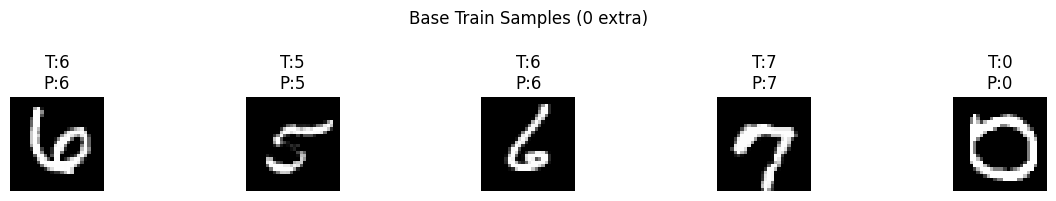

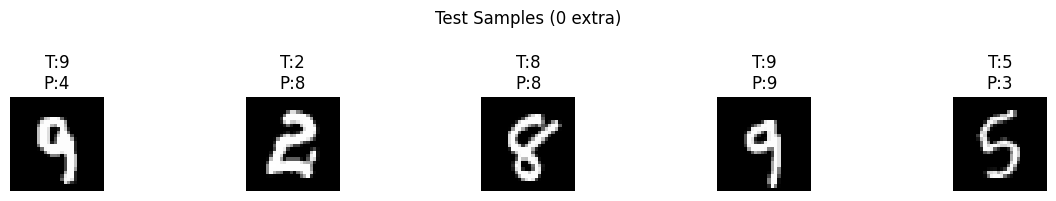

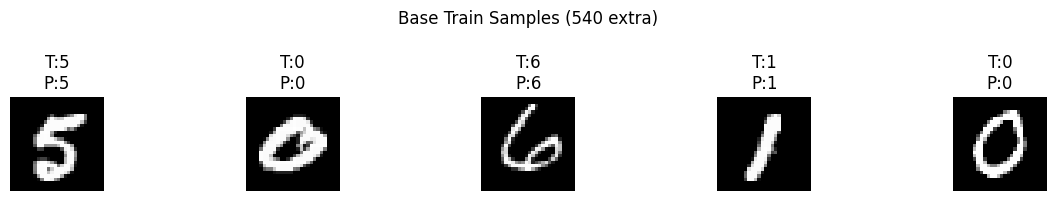

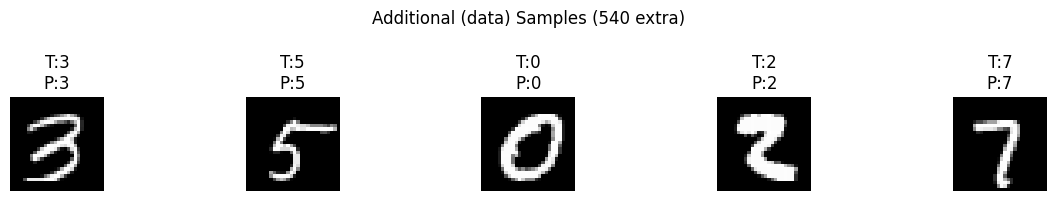

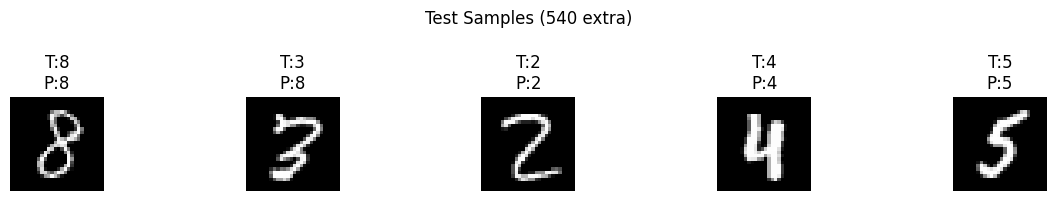

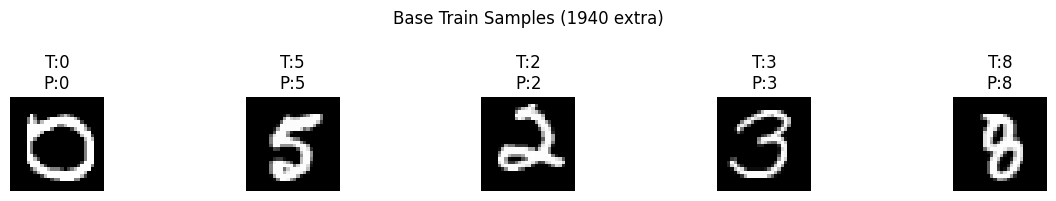

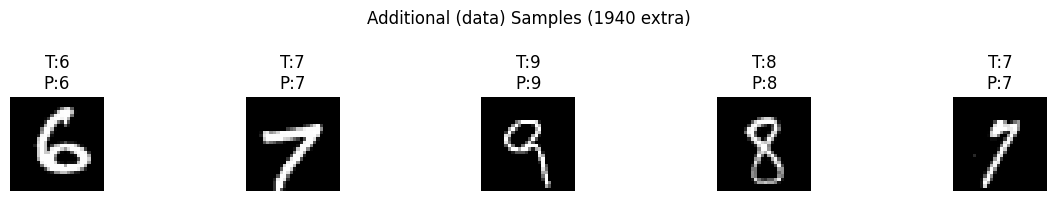

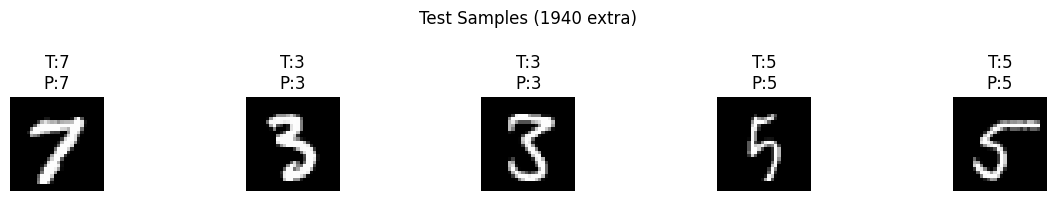

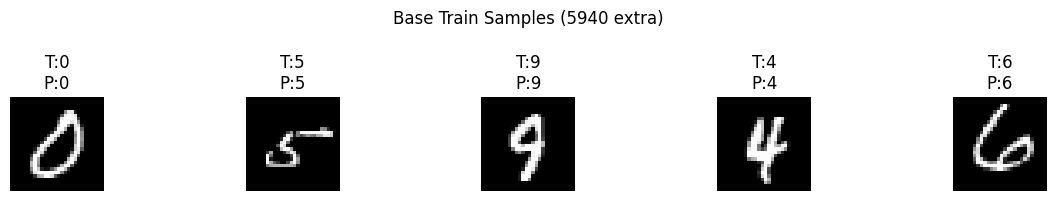

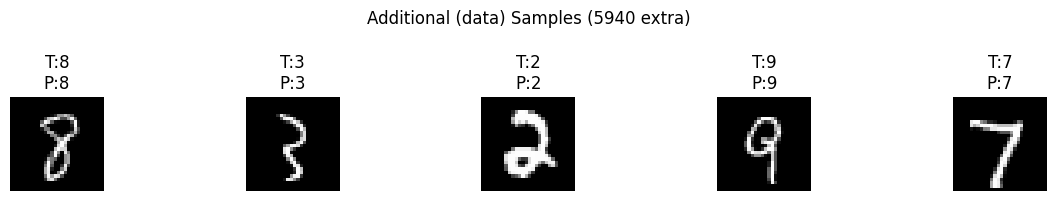

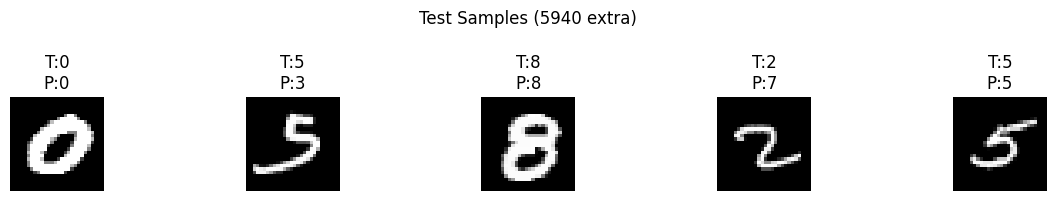

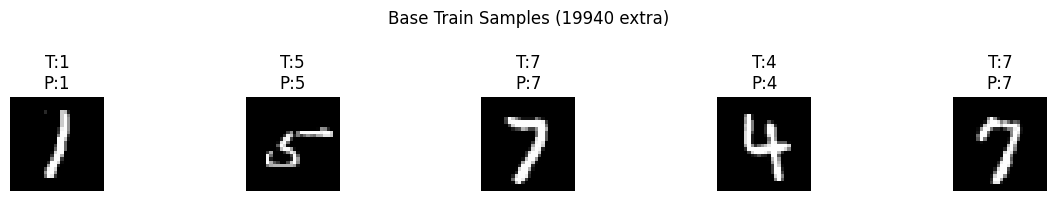

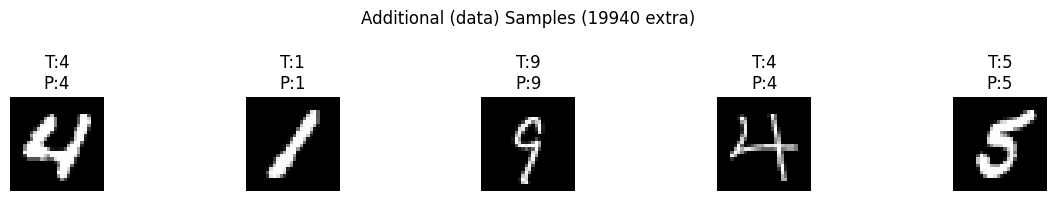

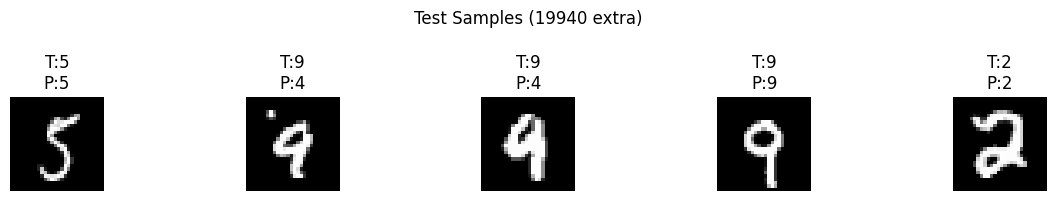

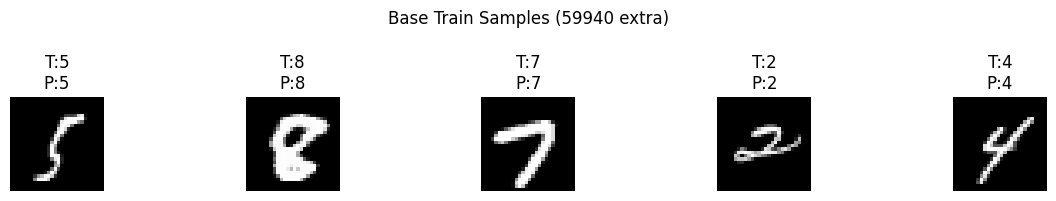

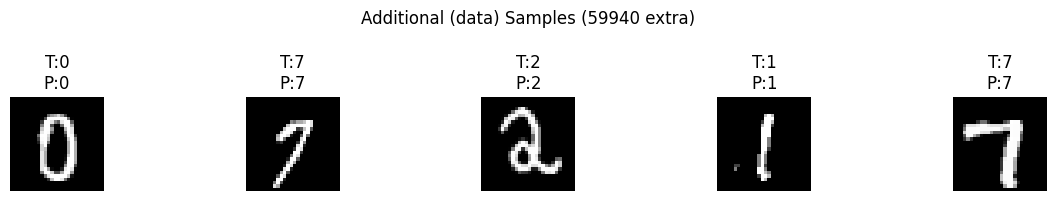

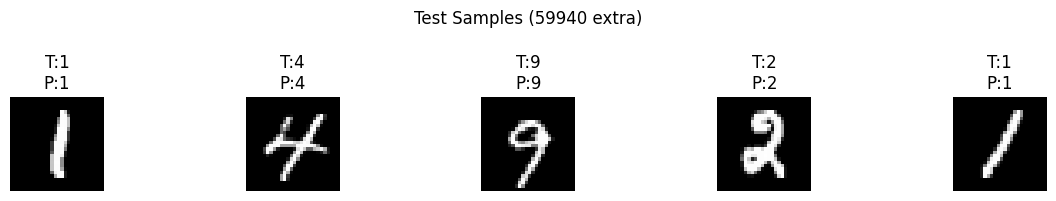

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
